In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/0408_data.zip'

-rw------- 1 root root 19653256 Apr  9 05:05 '/content/drive/My Drive/Colab Notebooks/datasets/0408_data.zip'


In [ ]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/0408_data.zip

In [ ]:
train_dir = '0408_data/data/train'
test_dir = '0408_data/data/test'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)


train_generator = train_datagen.flow_from_directory(train_dir,target_size = (640, 640),
                                                    batch_size = 40,class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(test_dir,target_size = (640, 640),
                                                    batch_size = 40,class_mode = 'binary')

Found 163 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (640, 640, 3))

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':       
    set_trainable = True

  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

conv_base.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 640, 640, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 640, 640, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 640, 640, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 320, 320, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 320, 320, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 320, 320, 128)     147584    
______________________________________________________________

In [ ]:
from keras import models, layers, optimizers

model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))   

model.summary()


model.compile(loss = 'binary_crossentropy', 
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 20, 20, 512)       14714688  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               52429056  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 67,144,001
Trainable params: 59,508,737
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
%%time

Hist = model.fit(train_generator, steps_per_epoch = 4, epochs = 10, validation_data = test_generator)

Epoch 1/10
4/4 [==============================] - 63s 3s/step - loss: 0.8730 - accuracy: 0.4550 - val_loss: 0.6988 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 14s 4s/step - loss: 0.5915 - accuracy: 0.6860 - val_loss: 0.5817 - val_accuracy: 0.6500
Epoch 3/10
4/4 [==============================] - 10s 3s/step - loss: 0.4308 - accuracy: 0.8233 - val_loss: 0.5323 - val_accuracy: 0.7000
Epoch 4/10
4/4 [==============================] - 8s 3s/step - loss: 0.3505 - accuracy: 0.9488 - val_loss: 0.4482 - val_accuracy: 0.8250
Epoch 5/10
4/4 [==============================] - 9s 2s/step - loss: 0.2525 - accuracy: 0.8919 - val_loss: 0.4463 - val_accuracy: 0.7500
Epoch 6/10
4/4 [==============================] - 8s 3s/step - loss: 0.2963 - accuracy: 0.8593 - val_loss: 0.3650 - val_accuracy: 0.9250
Epoch 7/10
4/4 [==============================] - 8s 2s/step - loss: 0.1380 - accuracy: 0.9886 - val_loss: 0.4272 - val_accuracy: 0.7250
Epoch 8/10
4/4 [======================

In [ ]:
loss, accuracy = model.evaluate(test_generator)
loss, accuracy

1/1 [==============================] - 2s 2s/step - loss: 0.2852 - accuracy: 0.9250


(0.2852323055267334, 0.925000011920929)

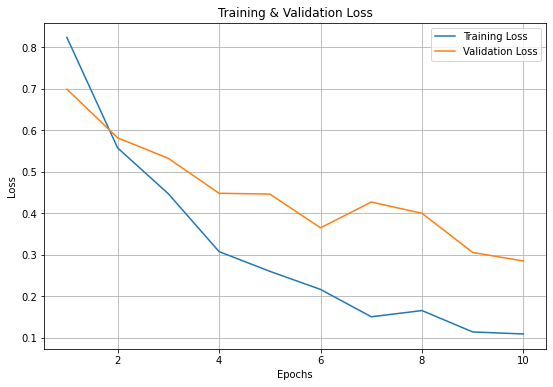

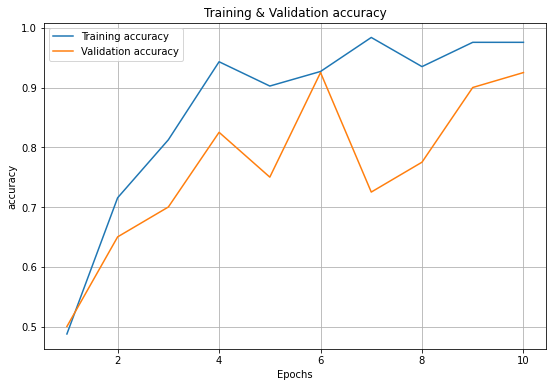

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist.history['loss'])
plt.plot(epochs, Hist.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist.history['accuracy'])
plt.plot(epochs, Hist.history['val_accuracy'])

plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

test_step = test_generator.samples // test_generator.batch_size

predictions = model.predict_generator(test_generator)
predicted_class = np.argmax(predictions, axis=1)

# true_class = test_generator.classes
# class_labels = list(test_generator.class_indices.keys())

# conf = confusion_matrix(true_class, predicted_class)

# print(conf)

print(len(predicted_class))
print(predicted_class)
print(predictions[:5])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

for t in test_generator:
  # (images, labels)
  # ((20,640,640,3) / 20)
  pred = [round(p[0]) for p in model.predict(t[0])]
  print(accuracy_score(t[1],pred))
  print(confusion_matrix(t[1], pred))
  break

0.925
[[19  1]
 [ 2 18]]


In [ ]:
import pathlib
from glob import glob

data_root = pathlib.Path(glob('/content/0408_data/data/*/')[1])
print(data_root)
# label = ['0','1']

/content/0408_data/data/test


In [ ]:
!ls /content/0408_data/data

test  train


In [ ]:
import random

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

image_count = len(all_image_paths)
print('image_count:', image_count)

image_count: 40


In [ ]:
import PIL.Image as Image
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
print(all_image_paths)
print(all_image_paths[0].split('/')[-2])
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print('image_count:', image_count)

def softmax(x):
  m = np.max(x)
  sm = np.exp(x-m)/np.sum(np.exp(x-m))
  return sm

plt.figure(figsize=(12,12))
for n in range(12):
  image_path = random.choice(all_image_paths)
  plt.subplot(4,3, n+1)
  plt.imshow(plt.imread(image_path))
  
  img = cv2.imread(image_path)
  #img= cv2.resize(img, dsize=(640,640))
  img = img/255.0
  img = np.expand_dims(img, axis=0)

  logits = model.predict(img)[0]
  prediction = softmax(logits)
  #print(prediction)
  a = prediction.tolist()
  a = sorted(a, reverse=True)
  # top = prediction.argsort()[::-1]
  # labels = [label[index] for index in top]
  # idx = int(image_path.split('/')[-2])
  plt.title(a)
  plt.axis('off')
plt.show()

In [ ]:
import cv2
plt.figure(figsize=(32,32))
def softmax(x):
  m = np.max(x)
  sm = np.exp(x-m)/ np.sum(np.exp(x-m))
  return sm
# predictions = model.predict_generator(test_generator)
for n in range(6):
  image_path = random.choice(all_image_paths)  # al_image_paths = test data 40개

  plt.subplot(6,2, n*2+1)
  plt.imshow(plt.imread(image_path))
  idx = int(image_path.split('/')[-2])


  plt.subplot(6,2,n*2+2)
  img = cv2.imread(image_path)
  img = cv2.resize(img, dsize=(640,640))
  img = img/255.0
  img = np.expand_dims(img, axis=0)

  logits = model.predict(img)[0]
  # prediction = softmax(logits)

  # top = prediction.argsort()[::-1]
  # labels = [label[index] for index in top]

  # plt.barh(range(2), prediction[top][::-1]*100)
  # plt.yticks(range(2), labels[::-1])
  plt.title(str(idx), ':::', logits)
  plt.axis('off')

In [ ]:
import cv2

plt.figure(figsize=((16, 25)))

def softmax(x):
    m = np.max(x)
    sm = np.exp(x - m)/np.sum(np.exp(x - m))
    return sm

for n in range(15):
    #랜덤 이미지 경로 추출
    image_path = random.choice(all_image_paths)

    #이미지 크기 변경 및 정규화
    img = cv2.imread(image_path)
    # img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0  # 3차원 행렬(224, 224, 3)
    img = np.expand_dims(img, axis=0)  # 4차원 (1, 224, 224, 3)

    # 이미지 분류
    logits = model.predict(img)[0]
    # prediction = softmax(logits)
    # arr = prediction.astype(np.int)
    # arr = prediction[0]

    #이미지 출력
    plt.subplot(5,3, n+1)
    plt.imshow(plt.imread(image_path))
    idx = image_path.split('/')[-2]
    plt.title('label: ' + str(idx))
    plt.xlabel(str(logits))
    #plt.xlabel(confusion_matrix(img, model.predict))
    # plt.xlabel(arr)

